# Installing packages

In [ ]:
!pip install librosa==0.8.1

# Importing libraries

In [101]:
# Standard library imports
import gc
import os
import pickle as pkl

# External library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Audio, display 
from tqdm.notebook import tqdm, trange

# Librosa related import
import librosa
from librosa import display as librosa_display

from sklearn import preprocessing

import essentia.standard as estd
from typing import List

# Load dataset

In [102]:
timit_path = '/kaggle/input/darpa-timit-acousticphonetic-continuous-speech'
data_path = timit_path+"/data"

# Helper Functions

In [103]:
def get_total_audio_durations(dict_data):
    """
    This function calculates the total duration of all audio files referenced in a given dictionary.
    
    Args:
    dict_data (dict): A dictionary containing paths to audio files.

    Returns:
    int: The total duration of all audio files in seconds.
    """
    total_duration_seconds = 0
    
    for entry in dict_data.values(): 
        audio_file_path = entry['audio_file']  # Extract the audio file path

        try:
            duration_seconds = librosa.get_duration(filename=audio_file_path)
            total_duration_seconds += duration_seconds
        except Exception as e:
            print(f"Error processing file {audio_file_path}: {e}")
            continue

    return int(total_duration_seconds)  # Return the total duration in seconds


# Data exploration

In [104]:
df_train = pd.read_csv(os.path.join(timit_path, 'train_data.csv'))
df_test = pd.read_csv(os.path.join(timit_path, 'test_data.csv'))
df = pd.concat([df_train, df_test])
df = df[df['is_converted_audio'] == False]



In [105]:
df

,index,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_phonetic_file,is_sentence_file
1,2.0,TRAIN,DR4,MMDM0,SI1311.PHN,TRAIN/DR4/MMDM0/SI1311.PHN,TRAIN\\DR4\\MMDM0\\SI1311.PHN,False,False,False,True,False
2,3.0,TRAIN,DR4,MMDM0,SI1311.WRD,TRAIN/DR4/MMDM0/SI1311.WRD,TRAIN\\DR4\\MMDM0\\SI1311.WRD,False,False,True,False,False
3,4.0,TRAIN,DR4,MMDM0,SX321.PHN,TRAIN/DR4/MMDM0/SX321.PHN,TRAIN\\DR4\\MMDM0\\SX321.PHN,False,False,False,True,False
4,5.0,TRAIN,DR4,MMDM0,SX321.WRD,TRAIN/DR4/MMDM0/SX321.WRD,TRAIN\\DR4\\MMDM0\\SX321.WRD,False,False,True,False,False
5,6.0,TRAIN,DR4,MMDM0,SI681.TXT,TRAIN/DR4/MMDM0/SI681.TXT,TRAIN\\DR4\\MMDM0\\SI681.TXT,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
8394,8395.0,TEST,DR8,MPAM0,SX19.WAV,TEST/DR8/MPAM0/SX19.WAV,TEST\\DR8\\MPAM0\\SX19.WAV,False,True,False,False,False
8395,8396.0,TEST,DR8,MPAM0,SX109.TXT,TEST/DR8/MPAM0/SX109.TXT,TEST\\DR8\\MPAM0\\SX109.TXT,False,False,False,False,True
8397,8398.0,TEST,DR8,MPAM0,SX289.WRD,TEST/DR8/MPAM0/SX289.WRD,TEST\\DR8\\MPAM0\\SX289.WRD,False,False,True,False,False
8398,8399.0,TEST,DR8,MPAM0,SX109.WAV,TEST/DR8/MPAM0/SX109.WAV,TEST\\DR8\\MPAM0\\SX109.WAV,False,True,False,False,False


In [106]:
data = {}

for idx, row in tqdm(df.iterrows()):
    path = row['path_from_data_dir']
    entry_id = path.split('.')[0]

    if entry_id not in data:
        data[entry_id] = {}

    if row['is_audio'] is True:
        data[entry_id]['audio_file'] = os.path.join(data_path, path)
    elif row['is_word_file'] is True:
        data[entry_id]['word_file'] = os.path.join(data_path, path)
    elif row['is_phonetic_file'] is True:
        data[entry_id]['phonetic_file'] = os.path.join(data_path, path)

0it [00:00, ?it/s]

In [107]:
print(f"Total Duration: {get_total_audio_durations(data) // 60} minutes")

Total Duration: 322 minutes


In [108]:
data_path

'/kaggle/input/darpa-timit-acousticphonetic-continuous-speech/data'

In [109]:
# Visualise a sample

filename = data_path + "/TRAIN/DR1/FECD0/SI1418.WAV"

# Load the audio file
audio, sample_rate = librosa.load(filename)

# Play the audio
display(Audio(audio, rate=sample_rate))

# Show the text
text_file_path = data_path + "/TRAIN/DR1/FECD0/SI1418.TXT"

# Open the file in read mode
with open(text_file_path, 'r') as file:
    # Read the contents of the file
    contents = file.read()

# Print the contents of the file
print(contents)

0 89191 Personal predispositions tend to blunt the ear and, in turn, the voice as well.



In [110]:
# Show the phoneme file with time steps
phoneme_file_path = data_path + "/TRAIN/DR1/FECD0/SI1418.PHN"

# Open the file in read mode
with open(phoneme_file_path, 'r') as file:
    # Read the contents of the file
    contents = file.read()

# Print the contents of the file
print(contents)    

0 2260 h#
2260 3310 p
3310 4920 er
4920 6750 s
6750 7600 en
7600 9680 el
9680 11140 pcl
11140 12290 p
12290 12766 r
12766 13584 iy
13584 14174 dcl
14174 14302 d
14302 15400 ih
15400 17478 s
17478 18292 pcl
18292 18651 p
18651 19509 ix
19509 20630 z
20630 21860 ih
21860 23910 sh
23910 24800 ix
24800 26970 n
26970 28657 s
28657 29290 tcl
29290 30040 t
30040 31400 eh
31400 32200 n
32200 33400 dcl
33400 34230 t
34230 34864 ix
34864 35800 bcl
35800 36480 b
36480 37306 l
37306 39106 ah
39106 39939 n
39939 41730 tcl
41730 42130 dh
42130 42691 ix
42691 44040 q
44040 46325 ey
46325 48600 ah
48600 52920 pau
52920 53478 q
53478 54847 eh
54847 55520 n
55520 56880 ih
56880 57680 n
57680 58800 tcl
58800 60210 t
60210 62618 er
62618 64052 n
64052 64924 ax
64924 66367 v
66367 69190 oy
69190 71249 s
71249 72173 q
72173 73080 ix
73080 74130 z
74130 74880 epi
74880 75860 w
75860 77312 eh
77312 78840 l
78840 89120 h#



## Visualising audio features

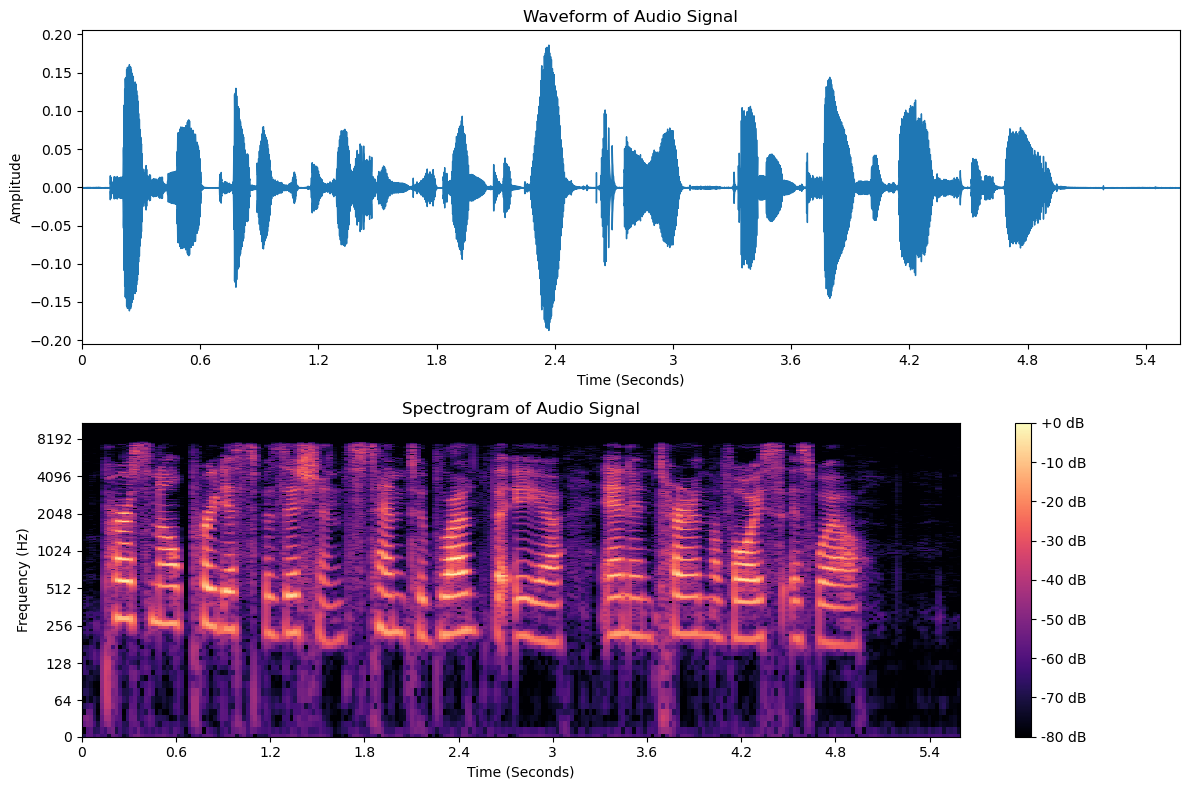

In [111]:
# Create a new figure for the waveform
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.title('Waveform of Audio Signal')
librosa.display.waveplot(audio, sr=sample_rate)
plt.xlabel('Time (Seconds)')
plt.ylabel('Amplitude')

# Generate and display a spectrogram
plt.subplot(2, 1, 2)
plt.title('Spectrogram of Audio Signal')
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (Seconds)')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()  # Ensure the plots don't overlap
plt.show()

In [112]:
mfccs = librosa.feature.mfcc(audio, sr=sample_rate)
print(mfccs.shape)

(20, 241)


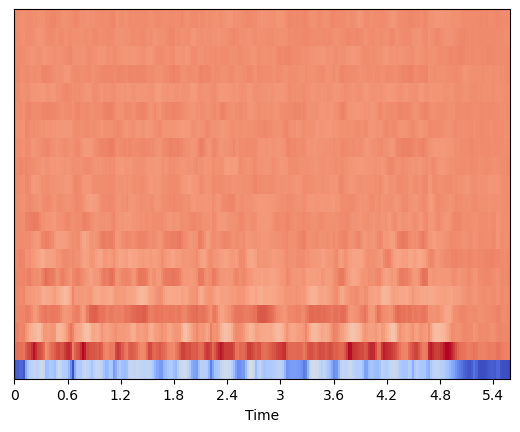

In [113]:
librosa_display.specshow(mfccs, sr=sample_rate, x_axis='time')

## Feature Scaling

In [114]:
# Normalize the MFCCs so that each coefficient dimension has a mean of zero and a variance of one.
mfccs = preprocessing.scale(mfccs, axis=1)
print(mfccs.mean(axis=1))
print(mfccs.var(axis=1))

[ 7.9143101e-09 -1.1871465e-08  2.4732218e-09  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -4.9464437e-09
  8.9035987e-09  1.1871465e-08 -9.8928874e-09 -7.9143101e-09
  7.9143101e-09  0.0000000e+00 -7.9143101e-09  7.9143101e-09
 -7.9143101e-09 -1.5828620e-08  0.0000000e+00 -7.9143101e-09]
[0.9999999  1.0000001  0.9999999  1.         1.         1.
 1.         0.9999999  0.99999994 1.         1.0000001  0.9999999
 1.0000001  1.         1.         0.9999999  1.         0.9999999
 1.0000001  1.        ]


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:259: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


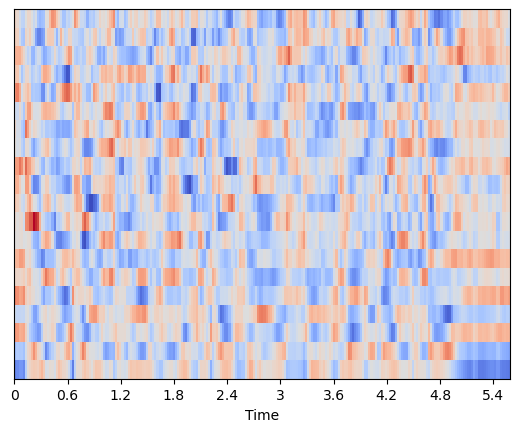

In [115]:

librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')

### We have the option to utilize essentia.standard.MFCC for computing MFCCs over a signal, which we can then represent visually as a 'MFCC-gram'

In [116]:
# Create the necessary essentia algorithm instances
window = estd.Windowing(type='hamming')
spectrum = estd.Spectrum()  # we just want the magnitude spectrum
mfcc_extractor = estd.MFCC(numberCoefficients=13)

# Parameters for frame processing
frame_size = 1024
hop_size = 500

# Compute MFCCs for each frame and store them in an array
mfccs = np.array([mfcc_extractor(spectrum(window(frame)))[1]
                  for frame in estd.FrameGenerator(audio, frameSize=frame_size, hopSize=hop_size)])

print(mfccs.shape)

(247, 13)


[   INFO   ] TriangularBands: input spectrum size (513) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.


In [117]:
# Scale the MFCCs
mfccs = preprocessing.scale(mfccs)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:259: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Text(0.5, 0, 'Frame Index')

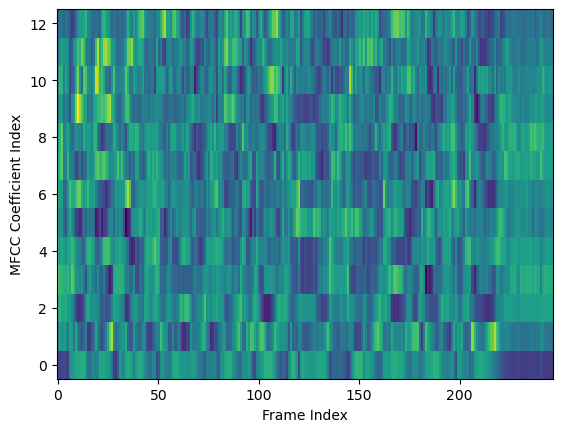

In [118]:
plt.imshow(mfccs.T, origin='lower', aspect='auto', interpolation='nearest')
plt.ylabel('MFCC Coefficient Index')
plt.xlabel('Frame Index')

# Build Dataset Preprocessor

In [119]:
class TIMIT_DATASET_PREPROCESSOR():
    # file names
    TRAINING_DATA_FILE = 'train_data.csv'
    TEST_DATA_FILE = 'test_data.csv'

    # directory paths
    DATA_DIRECTORY = './data'
    MAIN_DIRECTORY = './'

    # field names in CSV
    FIELD_PATH = 'path_from_data_dir' # field that contains file path in train_data.csv
    FIELD_IS_AUDIO = 'is_converted_audio' # boolean field that tells if the record in train_data.csv describes an audio file we're interested in
    FIELD_IS_PHONETIC = 'is_phonetic_file' # boolean field that tells if the record in train_data.csv describes a phonetic file
    FIELD_DIALECT_REGION = 'dialect_region' # field that contains dialect region information

    # windowing parameters for audio processing
    WINDOW_LENGTH = 0.025
    WINDOW_STEP = 0.01
    
    def __init__(self, path=None):
        """
        Class initialization method. Sets up directories and phonetic mappings.
        """
        self.main_directory = path

        # Handling the trailing slash in path
        if path and path[-1] != '/':
            self.main_directory += "/"
        
        self.data_directory = self.main_directory + "data/" if self.main_directory else None

        # Mapping from 61 phonemes to 39 phonemes
        self.phoneme_mapping_61_to_39 = {
            'iy':'iy', 'ih':'ih', 'eh':'eh', 'ae':'ae', 'ix':'ih', 'ax':'ah', 'ah':'ah', 'uw':'uw',
            'ux':'uw', 'uh':'uh', 'ao':'aa', 'aa':'aa', 'ey':'ey', 'ay':'ay', 'oy':'oy', 'aw':'aw',
            'ow':'ow', 'l':'l', 'el':'l', 'r':'r', 'y':'y', 'w':'w', 'er':'er', 'axr':'er', 'm':'m', 
            'em':'m', 'n':'n', 'nx':'n', 'en':'n', 'ng':'ng', 'eng':'ng', 'ch':'ch', 'jh':'jh', 'dh':'dh', 
            'b':'b', 'd':'d', 'dx':'dx', 'g':'g', 'p':'p', 't':'t', 'k':'k', 'z':'z', 'zh':'sh', 'v':'v', 
            'f':'f', 'th':'th', 's':'s', 'sh':'sh', 'hh':'hh', 'hv':'hh', 'pcl':'h#', 'tcl':'h#', 'kcl':'h#', 
            'qcl':'h#','bcl':'h#','dcl':'h#', 'gcl':'h#','h#':'h#', '#h':'h#', 'pau':'h#', 'epi': 'h#', 
            'nx':'n', 'ax-h':'ah','q':'h#'
        }

        # Set of all 61 phonemes
        self.phoneme_set_61 = list(self.phoneme_mapping_61_to_39.keys())

        # Set of all 39 phonemes
        self.phoneme_set_39 = list(set(self.phoneme_mapping_61_to_39.values()))

        # Mapping from phoneme to its label (id) and from label (id) to phoneme
        self.label_to_phoneme_39 = {}
        self.phoneme_to_label_39 = {}

        for index, phoneme in enumerate(self.phoneme_set_39):
            self.label_to_phoneme_39[phoneme] = index + 1
            self.phoneme_to_label_39[index + 1] = phoneme

        # Mapping from 39 phonemes to 61 phonemes
        self.phoneme_mapping_39_to_61 = {}

        for phoneme_61, phoneme_39 in self.phoneme_mapping_61_to_39.items():
            if phoneme_39 not in self.phoneme_mapping_39_to_61:
                self.phoneme_mapping_39_to_61[phoneme_39] = []
            self.phoneme_mapping_39_to_61[phoneme_39].append(phoneme_61)
            
    def get_phoneme_mapping(self, phoneme):
        """
        Get the equivalent 39 phoneme for a given 61 phoneme.
        """
        return self.phoneme_mapping_61_to_39[self.remove_phoneme_stress_marker(phoneme)]

    def remove_phoneme_stress_marker(self, phoneme):
        """
        Remove stress markers '1' and '2' from the given phoneme.
        """
        phoneme = phoneme.replace('1', '')
        phoneme = phoneme.replace('2', '')
        return phoneme

    def get_window_parameters(self, sample_rate):
        """
        Get the window parameters for the given sample rate.
        """
        FFT_SIZE = 512  # Fast Fourier Transform size
        window_length = self.WINDOW_LENGTH * sample_rate
        window_step = self.WINDOW_STEP * sample_rate
        return FFT_SIZE, int(window_length), int(window_step)

    def get_single_training_frame_size(self, sample_rate):
        """
        Get the size of a single training frame for the given sample rate.
        """
        return math.floor(sample_rate / 4)
        
    def read_training_data_description(self):
        """
        Read training data description from a CSV file and filter by dialect region.
        """
        # Check if the training data CSV file is in the correct path
        file_path = self.main_directory + self.TRAINING_DATA_FILE
        self.training_data = pd.read_csv(file_path)

        # Remove entries not belonging to the specified dialect regions
        valid_dialect_regions = ['DR1','DR2','DR3','DR4','DR5','DR6','DR7','DR8']
        self.training_data = self.training_data[self.training_data[self.FIELD_DIALECT_REGION].isin(valid_dialect_regions)]
        
        return self.training_data

    def read_testing_data_description(self):
        """
        Read testing data description from a CSV file and filter by dialect region.
        """
        # Check if the testing data CSV file is in the correct path
        file_path = self.main_directory + self.TEST_DATA_FILE
        self.testing_data = pd.read_csv(file_path)

        # Remove entries not belonging to the specified dialect regions
        valid_dialect_regions = ['DR1','DR2','DR3','DR4','DR5','DR6','DR7','DR8']
        self.testing_data = self.testing_data[self.testing_data[self.FIELD_DIALECT_REGION].isin(valid_dialect_regions)]
        
        return self.testing_data

    def get_audio_files(self, type='Train'):
        """
        Get a list of audio files from either the training or testing data.
        """
        if type == 'Train':
            self.read_training_data_description()
            return self.training_data[self.training_data[self.FIELD_IS_AUDIO] == True]
        elif type == 'Test':
            self.read_testing_data_description()
            return self.testing_data[self.testing_data[self.FIELD_IS_AUDIO] == True]
        
    def get_phoneme_files(self, type='Train'):
        """
        Get a list of phoneme files from either the training or testing data.
        """
        if type == 'Train':
            self.read_training_data_description()
            return self.training_data[self.training_data[FIELD_IS_PHONETIC] == True]
        elif type == 'Test':
            self.read_testing_data_description()
            return self.testing_data[self.testing_data[FIELD_IS_PHONETIC] == True]

    def load_audio(self, file_path=None, apply_pre_emphasis=False):
        """
        Load an audio file and optionally apply pre-emphasis.
        If the file path is None or the file does not exist, return an array of zeros.
        """
        if file_path is None:
            return np.zeros(1), 0

        file_path = self.data_directory + file_path

        if os.path.exists(file_path):
            audio_signal, sample_rate = librosa.load(file_path, sr=None)
            
            if apply_pre_emphasis:
                audio_signal = librosa.effects.preemphasis(audio_signal)
            
            return audio_signal, sample_rate   
        else:
            return np.zeros(1), 0
        
    def load_phonemes(self, file_path=None):
        """
        Load phonemes from a file. If the file path is not provided, an exception is raised.
        """
        if file_path is None:
            raise Exception('Phoneme file path not provided')
        
        file_path = self.data_directory + file_path
        phonemes = pd.read_csv(file_path, sep=" ")

        return phonemes
    
    def extract_features_and_labels(self, feature_type='mfcc', audio_path=None, phoneme_path=None, num_mels=128, delta=False, delta_delta=False):
        """
        Function to extract feature and labels from audio and phoneme files.
        """
        if audio_path is None:
            raise Exception("Path to audio (Wav) file must be provided")

        # Read and pre-emphasize audio
        audio_waveform, sample_rate = self.load_audio(file_path=audio_path, apply_pre_emphasis=True)

        # Get window parameters
        nfft, window_length, window_step = self.get_window_parameters(sample_rate)

        # Extract Mel-frequency cepstral coefficients (MFCCs)
        if(feature_type == 'mfcc'):
            mel_spectrogram = librosa.feature.mfcc(
                audio_waveform, sr=sample_rate, 
                hop_length=window_step, win_length=window_length, 
                n_fft=nfft, n_mfcc=num_mels
            )

        # Convert to dB
        db_mel_spectrogram = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)

        mel_delta = None
        mel_delta_delta = None
        # Compute delta and delta-delta if needed
        if delta:
            mel_delta = librosa.feature.delta(db_mel_spectrogram)
            if delta_delta:
                mel_delta_delta = librosa.feature.delta(mel_delta)

        # Read phoneme transcription
        if phoneme_path is None:
            split_audio_path = audio_path.split('/')
            phoneme_path = "/".join(split_audio_path[:-1]) + "/" + split_audio_path[-1].split('.WAV')[0] + ".PHN"

        audio_phoneme_transcription = self.load_phonemes(phoneme_path)            
        time_steps = db_mel_spectrogram.shape[1]

        feature_vectors = []
        db_mel_spectrogram = db_mel_spectrogram.T
        mel_delta = mel_delta.T
        mel_delta_delta = mel_delta_delta.T

        previous_phoneme = None
        first_transcription = audio_phoneme_transcription.columns
        audio_phoneme_transcription.columns = ['start', 'end', 'phoneme']
        phoneme_labels = []
    
        for i in range(time_steps):
            # Collecting feature vector
            feature = np.zeros(num_mels * 3)
            feature[:num_mels] = db_mel_spectrogram[i]
            feature[num_mels:num_mels * 2] = mel_delta[i]
            feature[num_mels * 2:num_mels * 3] = mel_delta_delta[i]
            feature_vectors.append(feature)

            # Collecting phoneme label
            start_time = window_step * i
            end_time = start_time + window_length
            current_phoneme_list = list(
                        audio_phoneme_transcription[
                            ((audio_phoneme_transcription['start'] <= start_time) & 
                            ((audio_phoneme_transcription['end'] - start_time) >= int(window_length / 1.5)))
                            |
                            ((audio_phoneme_transcription['start'] <= end_time) & 
                                (audio_phoneme_transcription['end'] > end_time))  
                        ].to_dict()['phoneme'].values()
            )
            if len(current_phoneme_list) == 0:
                if int(first_transcription[1]) > start_time:
                    current_phoneme = first_transcription[2]
                else:
                    current_phoneme = previous_phoneme
            else:
                current_phoneme = current_phoneme_list[0]

            current_phoneme = self.get_phoneme_mapping(current_phoneme)
            previous_phoneme = current_phoneme
            phoneme_labels.append(current_phoneme)

        return feature_vectors, phoneme_labels

    
    def prepare_labels_for_training(self, labels: List[str]) -> List[List[int]]:
        """
        Prepare labels for training.
        """
        print('Preparing Labels')

        label_vectors = []

        # Progress bar
        progress_bar = tqdm(range(len(labels)))

        for i, label in enumerate(labels):
            # One-hot encode label
            one_hot_label = [0] * 39
            one_hot_label[self.label_to_phoneme_39[label] - 1] = 1
            label_vectors.append(one_hot_label)

            # Update progress bar every 500 iterations
            if i % 500 == 0:
                progress_bar.set_description(f'Working on phoneme {label}')
                progress_bar.update(500)

        progress_bar.set_description(f'Working on phoneme {label}')
        progress_bar.update(len(labels) % 500) 

        return label_vectors


    def collect_features(self, dataset_type='Train', feature_type='mfcc', num_mels=128, delta=False, delta_delta=False):
        """
        Collect features and corresponding labels.
        """
        audio_files = self.get_audio_files(dataset_type)
        audio_files.reset_index(drop=True, inplace=True)

        feature_vectors = []
        labels = []

        # Progress bar
        progress_bar = tqdm(range(audio_files.shape[0]))

        for i in range(audio_files.shape[0]):
            file_path = audio_files.loc[i][self.FIELD_PATH]
            features, file_labels = self.extract_features_and_labels(
                feature_type=feature_type, 
                audio_path=file_path, 
                num_mels=num_mels, 
                delta=delta, 
                delta_delta=delta_delta
            )

            progress_bar.set_description(f'Working on {file_path}, index: {i}')
            progress_bar.update()

            feature_vectors.extend(features)
            labels.extend(file_labels)

        print(f"length of feature_vectors is {len(feature_vectors)} and length of labels is {len(labels)}")

        labels = np.asarray(self.prepare_labels_for_training(labels), dtype=np.int16)
        feature_vectors = np.asarray(feature_vectors, dtype=np.float32)

        return feature_vectors, labels

    

In [120]:
gc.collect()
tdp = TIMIT_DATASET_PREPROCESSOR(timit_path)
n_mels = 64
delta = True
delta_delta=True
ftype = 'mfcc'



# Prepare and Save Training Data

In [121]:
print('Collecting Features from Audio Files')
features,labels = tdp.collect_features(feature_type=ftype,num_mels=n_mels,delta=delta,delta_delta=delta_delta)

print('--- Completed')

gc.collect()

  0%|          | 0/4620 [00:00<?, ?it/s]

length of feature_vectors is 1421707 and length of labels is 1421707
Preparing Labels


  0%|          | 0/1421707 [00:00<?, ?it/s]

--- Completed


38

In [122]:
#-------------
train_features_file = open("/kaggle/working/features.pkl",'wb')
pkl.dump(features, train_features_file)
train_labels_file = open("/kaggle/working/labels.pkl",'wb')
pkl.dump(labels, train_labels_file)            
train_features_file.close()
train_labels_file.close()

In [123]:
print(features.shape)
print(labels.shape)

(1421707, 192)
(1421707, 39)


# Prepare and Save Testing Data

In [124]:
gc.collect()
print('Collecting Testing Features from Audio Files')
test_features,test_labels = tdp.collect_features(dataset_type='Test',feature_type=ftype,num_mels=n_mels,delta=delta,delta_delta=delta_delta)
print('--- Completed')
gc.collect()


  0%|          | 0/1680 [00:00<?, ?it/s]

length of feature_vectors is 519525 and length of labels is 519525
Preparing Labels


  0%|          | 0/519525 [00:00<?, ?it/s]

--- Completed


38

In [125]:
test_features_file = open("/kaggle/working/test_features.pkl",'wb')
pkl.dump(test_features,test_features_file)
test_labels_file = open("/kaggle/working/test_labels.pkl",'wb')
pkl.dump(test_labels,test_labels_file)            
test_features_file.close()
test_labels_file.close()